# Analyze A/B Test Results 

This project will assure you have mastered the subjects covered in the statistics lessons. We have organized the current notebook into the following sections: 

- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)
- [Final Check](#finalcheck)
- [Submission](#submission)


<a id='intro'></a>
## Introduction

A/B tests are very commonly performed by data analysts and data scientists. For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should:
- Implement the new webpage, 
- Keep the old webpage, or 
- Perhaps run the experiment longer to make their decision.


<a id='probability'></a>
## Part I - Probability

To get started, let's import our libraries.

In [5]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

**a.** Read in the dataset from the `ab_data.csv` file and take a look at the top few rows here:

In [6]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


**b.** Use the cell below to find the number of rows in the dataset.

In [7]:
df.shape[0]

294478

**c.** The number of unique users in the dataset.

In [8]:
df.user_id.nunique()

290584

**d.** The proportion of users converted.

In [9]:
df.query('converted == 1')['user_id'].count()/ df.query('converted')['user_id'].count()

0.11965919355605512

**e.** The number of times when the "group" is `treatment` but "landing_page" is not a `new_page`.

In [10]:
tre_group = df.query('group == "treatment" and landing_page != "new_page"')['user_id'].count() # for treatment group 
con_group = df.query('group == "control" and landing_page != "old_page"')['user_id'].count() # for control group 

In [11]:
tre_group + con_group # the total 

3893

In [12]:
df.isnull().any() # There is no missing values 

user_id         False
timestamp       False
group           False
landing_page    False
converted       False
dtype: bool

**a.** Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [13]:
# Remove the inaccurate rows, and store the result in a new dataframe df2
df2 = df.drop(df[((df['group'] == 'treatment') & (df['landing_page'] != 'new_page')) | 
              ((df['group'] == 'control') & (df['landing_page'] == 'new_page'))].index)

In [14]:
# Double Check all of the incorrect rows were removed from df2 - 
# Output of the statement below should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

**a.** How many unique **user_id**s are in **df2**?

In [15]:
df2.user_id.nunique()

290584

**b.** There is one **user_id** repeated in **df2**.  What is it?

In [16]:
df2.user_id.duplicated().sum()

1

**c.** Display the rows for the duplicate **user_id**? 

In [17]:
df2[df2.user_id.duplicated()]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


**d.** Remove **one** of the rows with a duplicate **user_id**, from the **df2** dataframe.

In [18]:
df2.drop(2893, inplace= True)

# Check again if the row with a duplicate user_id is deleted or not
df2.user_id.duplicated().sum()

0

**a.** What is the probability of an individual converting regardless of the page they receive?<br><br>

In [19]:
df2['converted'].mean()

0.11959708724499628

**b.** Given that an individual was in the `control` group, what is the probability they converted?

In [20]:
control_con = df2[df2['group'] == "control"]['converted'].mean()

**c.** Given that an individual was in the `treatment` group, what is the probability they converted?

In [21]:
treatment_con = df2[df2['group'] == "treatment"]['converted'].mean()

In [22]:
# Calculate the actual difference (obs_diff) between the conversion rates for the two groups.
obs_diff = treatment_con - control_con 
obs_diff

-0.0015782389853555567

**d.** What is the probability that an individual received the new page?

In [23]:
(df2.landing_page == "new_page").mean()

0.5000619442226688

**e.** Consider your results from parts (a) through (d) above, and explain below whether the new `treatment` group users lead to more conversions.

- **Based on the results, there is slightly differnce between the control and treatment groups , but dose not shown that the treatment group users lead to more conversions, therefore we conclude that the conrtol group lead to more conclusion with a slight difference.**

<a id='ab_test'></a>
## Part II - A/B Test

Since a timestamp is associated with each event, you could run a hypothesis test continuously as long as you observe the events. 

However, then the hard questions would be: 
- Do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  
- How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  



**1.** For now, consider you need to make the decision just based on all the data provided.  


If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should be your null and alternative hypotheses (**$H_0$** and **$H_1$**)?  

You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the "converted" probability (or rate) for the old and new pages respectively.

<center> $H_0$ :  $p_{new}$ - $p_{old}$  <= 0 <br>
         $H_1$ :  $p_{new}$ - $p_{old}$ > 0
</center>

**2.** - Null Hypothesis $H_0$ Testing
Under the null hypothesis $H_0$, assume that $p_{new}$ and $p_{old}$ are equal. Furthermore, assume that $p_{new}$ and $p_{old}$ both are equal to the **converted** success rate in the `df2` data regardless of the page. So, our assumption is: <br><br>
<center>
$p_{new}$ = $p_{old}$ = $p_{population}$
</center>

**a.** What is the **conversion rate** for $p_{new}$ under the null hypothesis? 

In [24]:
p_new = df2['converted'].mean()

**b.** What is the **conversion rate** for $p_{old}$ under the null hypothesis? 

In [25]:
p_old = df2['converted'].mean()

**c.** What is $n_{new}$, the number of individuals in the treatment group? <br><br>
*Hint*: The treatment group users are shown the new page.

In [26]:
n_new = df2.query('group == "treatment" and landing_page == "new_page"')['user_id'].count()
n_new

145310

**d.** What is $n_{old}$, the number of individuals in the control group?

In [27]:
n_old = df2.query('group == "control" and landing_page == "old_page"')['user_id'].count()
n_old

145274

**e. Simulate Sample for the `treatment` Group**<br> 
Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null hypothesis.  <br><br>

In [28]:
# Simulate a Sample for the treatment Group
new_page_converted = np.random.choice([0,1],n_new, p=[p_new,1-p_new])

**f. Simulate Sample for the `control` Group** <br>
Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null hypothesis. <br> Store these $n_{old}$ 1's and 0's in the `old_page_converted` numpy array.

In [29]:
# Simulate a Sample for the control Group
old_page_converted = np.random.choice([0,1],n_old, p=[p_old,1-p_old])

**g.** Find the difference in the "converted" probability $(p{'}_{new}$ - $p{'}_{old})$ for your simulated samples from the parts (e) and (f) above. 

In [30]:
ob_diff = new_page_converted.mean() - old_page_converted.mean() 
ob_diff

0.0022387011003828228


**h. Sampling distribution** <br>
Re-create `new_page_converted` and `old_page_converted` and find the $(p{'}_{new}$ - $p{'}_{old})$ value 10,000 times using the same simulation process you used in parts (a) through (g) above. 

In [31]:
# Sampling distribution 
p_diffs = []
new_means, old_means = [] , []
size = df2.shape[0]

for _ in range(10000):
    new_page_co= np.random.choice(2,n_new, p=[p_new,1-p_new])
    old_page_co = np.random.choice(2,n_old, p=[p_old,1-p_old])
    p_diffs.append(new_page_co.mean() - old_page_co.mean())

**i. Histogram**<br> 
Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.<br><br> 

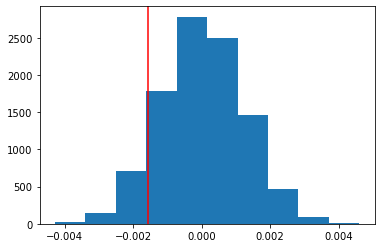

In [32]:
plt.hist(p_diffs);
plt.axvline(x=obs_diff, color='r');

In [33]:
p_diffs = np.array(p_diffs)
p_diffs

array([ 0.00068343, -0.00124376,  0.00071094, ...,  0.00079355,
       -0.00160841,  0.00013301])

**j.** What proportion of the **p_diffs** are greater than the actual difference observed in the `df2` data?

In [34]:
actual_diff = df[df['group'] == 'treatment']['converted'].mean() - df[df['group'] == "control"]['converted'].mean()

(p_diffs > obs_diff).mean()

0.9062

**k.** Please explain in words what you have just computed in part **j** above.  
 - What is this value called in scientific studies?  
 - What does this value signify in terms of whether or not there is a difference between the new and old pages? *Hint*: Compare the value above with the "Type I error rate (0.05)". 

- **we have computed the p-value which the value is 90% , therefore we cannot reject the null hypothesis and we should keep with the old page .**

**l. Using Built-in Methods for Hypothesis Testing**<br>
We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. 

In [35]:
import statsmodels.api as sm

# number of conversions with the old_page
convert_old = df2.query('group == "control" and converted == 1').count()['converted']

# number of conversions with the new_page
convert_new = df2.query('group == "treatment" and converted == 1').count()['converted']

# number of individuals who were shown the old_page
n_old = df2[df2['group'] == 'control']['converted'].count()

# number of individuals who received new_page
n_new = df2[df2['group'] == 'treatment']['converted'].count()

In [36]:
convert_old, convert_new , n_old, n_new

(17489, 17264, 145274, 145310)

**m.** Now use `sm.stats.proportions_ztest()` to compute your test statistic and p-value.  [Here](https://www.statsmodels.org/stable/generated/statsmodels.stats.proportion.proportions_ztest.html) is a helpful link on using the built in.

In [37]:
import statsmodels.api as sm
z_score, p_value = sm.stats.proportions_ztest([convert_new,convert_old], [n_new,n_old], alternative = 'larger')
print(z_score, p_value)

-1.3109241984234394 0.9050583127590245


**n.** What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?<br><br>


- **The result shows a z-score of -1.31 corresponds to the p-value is 0.905 the same as the findings in part j and k, Therefore we can say the we cannot reject the null hypothesis.**

<a id='regression'></a>
### Part III - A regression approach

 
**3.** In this final part, you will see that the result you achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

**a.** Since each row in the `df2` data is either a conversion or no conversion, what type of regression should you be performing in this case?

>**A Logistic Regression.**

**b.** The goal is to use **statsmodels** library to fit the regression model you specified in part **a.** above to see if there is a significant difference in conversion based on the page-type a customer receives. However, you first need to create the following two columns in the `df2` dataframe:
 1. `intercept` - It should be `1` in the entire column. 
 2. `ab_page` - It's a dummy variable column, having a value `1` when an individual receives the **treatment**, otherwise `0`.  

In [38]:
df2.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [39]:
df2['intercept'] = 1

df2['ab_page'] =pd.get_dummies(df2['group'])['treatment']
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


**c.** Use **statsmodels** to instantiate your regression model on the two columns you created in part (b). above, then fit the model to predict whether or not an individual converts. 


In [40]:
import statsmodels.api as sm
# instantiate logistic regression model
lom1 = sm.Logit(df2['converted'], df2[['intercept','ab_page']])
results = lom1.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


**d.** Provide the summary of your model below, and use it as necessary to answer the following questions.

In [41]:
results.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212780.3502
Date:               2022-10-04 11:41 BIC:              212801.5095
No. Observations:   290584           Log-Likelihood:   -1.0639e+05
Df Model:           1                LL-Null:          -1.0639e+05
Df Residuals:       290582           LLR p-value:      0.18988    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9888    0.0081  -246.6690  0.0000  -2.0046  -1.9730
ab_page      -0.0150    0.0114    -1.3109  0.1899  -0.0374   0.0074
==================================================================

"""

**e.** What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  

**The p-value associated with ab_page is different than part j and k. The reason is that the logistic model is based on a two-tailed test, but still the results shows a p-value larger than type I error, which means the new landing page is not statistically significant.**

**f.** Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

- **We should consider other factors that might influences the regression model like Change aversion and novelty effect that are the common factors that could produce a bias results.** <br><br>

- **The disadvantages of adding additional variables is that it may cause the problem of multicollinearity.**

**g. Adding countries**<br> 
Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. 

In [42]:
# Read the countries.csv
df_countries = pd.read_csv('countries.csv')
df_countries.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [43]:
# Join with the df2 dataframe
df_merged = df_countries.set_index('user_id').join(df2.set_index('user_id'), how='inner')
df_merged.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page
user_id,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1


In [44]:
# Create the necessary dummy variables
df_merged[['US','UK','CA']] = pd.get_dummies(df_merged['country'])

df_merged = df_merged.drop('UK', axis = 1)

df_merged.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page,US,CA
user_id,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,0,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,0,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0,0


In [45]:
# Fit your model, and summarize the results
lom2 = sm.Logit(df_merged['converted'], df_merged[['intercept','ab_page','US','CA']])
results = lom2.fit()
results.summary2()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212781.1253
Date:               2022-10-04 11:41 BIC:              212823.4439
No. Observations:   290584           Log-Likelihood:   -1.0639e+05
Df Model:           3                LL-Null:          -1.0639e+05
Df Residuals:       290580           LLR p-value:      0.17599    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9794    0.0127  -155.4145  0.0000  -2.0044  -1.9544
ab_page      -0.0149    0.0114    -1.3069  0.1912  -0.0374   0.0075
US           -0.0506    0.0284    -1.7835  0.0745  -0.1063   0.0050
CA           -0.0099    0.0133    -0.7433  0.4573  -0.0359   0.0162
==================================================================

"""

- **The results of the p-value is larger than the type I error, which means the country is not statistically significant effect on conversion.Therefore, we cannot reject the null hypothesis.**

**h. Fit your model and obtain the results**<br> 
Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if are there significant effects on conversion.  **Create the necessary additional columns, and fit the new model.** 


Provide the summary results (statistical output), and your conclusions (written response) based on the results. 

In [46]:
df_merged['ab_page_US'] = df_merged['ab_page'] * df_merged['US']
df_merged['ab_page_CA'] = df_merged['ab_page'] * df_merged['CA']

lom3 = sm.Logit(df_merged['converted'], df_merged[['intercept','ab_page','US','CA','ab_page_US','ab_page_CA']])
results = lom3.fit()
results.summary2()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212782.6602
Date:               2022-10-04 11:41 BIC:              212846.1381
No. Observations:   290584           Log-Likelihood:   -1.0639e+05
Df Model:           5                LL-Null:          -1.0639e+05
Df Residuals:       290578           LLR p-value:      0.19199    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9922    0.0161  -123.4571  0.0000  -2.0238  -1.9606
ab_page       0.0108    0.0228     0.4749  0.6349  -0.0339   0.0555
US           -0.0118    0.0398    -0.2957  0.7674  -0.0899   0.0663
CA            0.0057    0.0188     0.3057  0.7598  -0.0311   0.0426
ab_page_US   -0.0783    0.0568    -1.3783  0.1681  -0.1896   0.0330
ab_page_CA   -0.0314    0.0266    -1.1807  0.2377  -0.0835   0.0207
==================================================================

"""

- **Based on our model, the result does not show a significant effect on conversion due to a p-value higher than the type I error.Therefore, we cannot reject the null hypotheisi.**

## Conclusion

- **The results didnt approve that the new page would be better than the old.**
- **Hence, we cannot reject the null hypothesis, and should keep the old page.**

## Resources

- https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.join.html
- https://www.statsmodels.org/stable/generated/statsmodels.stats.proportion.proportions_ztest.html